In [ ]:
from fastrenewables.tabular.learner import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
from fastrenewables.metrics import crps_for_quantiles
import pandas as pd
import zipfile
import zipfile, re, os
import numpy as np
from fastai.torch_basics import *
from fastai.metrics import rmse, mae
from fastai.tabular.all import *
import seaborn as sns
import properscoring as ps
import dcor


In [ ]:
# pip install dcor
# pip install properscoring

In [ ]:
def read_single_file(file_name):
    df = pd.read_hdf(file_name, key="powerdata")
    return df

In [ ]:
def extract_single_file(path_to_zip_file, directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(path=directory_to_extract_to)

In [ ]:
def extract_zip_in_folder(toFolder):
    for root, dirs, files in os.walk(toFolder):
        for filename in files:
            if re.search(r'\.zip$', filename):
                fileSpec = os.path.join(root, filename)
                extract_single_file(fileSpec, root)

In [ ]:
def get_wind_speed(x, y):
    z = np.sqrt(x ** 2 + y ** 2)
    return z

def get_wind_direction(x, y):
    z = get_wind_speed(x, y)
    phi = 2 * np.arctan(y / (x + z + 1e-16))
    return phi

In [ ]:
def read_csv(file_name):
    df = pd.read_csv(file_name, sep=",")
    df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, infer_datetime_format=True, utc=True)
    df = df.rename(columns={"TIMESTAMP": "TimeUTC", "TARGETVAR": "PowerGeneration", "ZONEID":"TaskID"})
    df.set_index("TimeUTC", inplace=True)
    
    return df

In [ ]:
def create_complete_task(file_name_task, file_name_solution=None):
    df = read_csv(file_name_task)
    
    cols = [("U10", "V10"),("U100", "V100")]
        
    for c in cols:
        ws = get_wind_speed(df[c[0]].values, df[c[1]].values)
        wd = get_wind_direction(df[c[0]].values, df[c[1]].values)
        w_height = "100" if "100" in c[0] else "10"
        
        df[f"WindSpeed{w_height}m"] = ws
        df[f"SinWindDirection{w_height}m"] = np.sin(wd)
        df[f"CosWindDirection{w_height}m"] = np.cos(wd)   
    
    df["WindSpeed10m_t_m1"] = df.WindSpeed10m.shift(1).fillna(method='bfill')
#     df["WindSpeed10m_t_p1"] = df.WindSpeed10m.shift(-1).fillna(method='ffill')
    
    df["WindSpeed100m_t_m1"] = df.WindSpeed100m.shift(1).fillna(method='bfill')
#     df["WindSpeed100m_t_p1"] = df.WindSpeed100m.shift(-1).fillna(method='ffill')
    
    if file_name_solution is not None:
        df_solution = read_csv(file_name_solution)
        df_solution = df_solution[df_solution.TaskID==df.TaskID[0]]
        
#         check if timestamps match
        if (df.index == df_solution.index).sum() == df.shape[0]:
            
            df["PowerGeneration"] = df_solution.PowerGeneration.values
        else:
            raise Warning("Timestamps do not match.")
    df.dropna(inplace=True)
    return df  

In [ ]:
def merge_dfs(first_list, second_list):
    dfs = []
    if len(first_list)!= len(second_list):
        raise ValueError("Different lenghts of list.")
        
    for idx in range(len(first_list)):
        df1, df2 = first_list[idx], second_list[idx]
        if df1.TaskID[0] != df2.TaskID[0]:
            raise ValueError("Not sorted correctly. Not matching task ids.")
        dfs.append(pd.concat([df1, df2], axis=0))
        
    return dfs

In [ ]:
def prepare_for_tasks(dfs, gefcom_task=1):
    
    start_date = pd.to_datetime("2012-10-01", utc=True) + pd.DateOffset(months=gefcom_task-1)
    end_date = last_day_of_month(start_date)
    
    dfs_train = []
    for df in dfs:
        mask = df.index < start_date
        dfs_train.append(df[mask])
        
    dfs_test = []
    for df in dfs:
        mask = (df.index >= start_date) & (df.index <= end_date)
        dfs_test.append(df[mask])

    return pd.concat(dfs_train, axis=0), pd.concat(dfs_test, axis=0)

In [ ]:
import datetime

def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [ ]:
# uncomment if file is not yet downloaded

# !wget "https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip"
# extract_single_file("GEFCom2014.zip", "./")
# extract_single_file("GEFCom2014 Data/GEFCom2014-W_V2.zip", "./")
# extract_zip_in_folder("./Wind/")

In [ ]:
ls

'GEFCom2014 Data'/   gefcom.ipynb   preprocessing.py
 GEFCom2014.zip      models/        Wind/


In [ ]:
files_task = !ls {"./Wind/Task\ 15/Task15_W_Zone1_10/*csv"}

In [ ]:
dfs_task = [create_complete_task(f) for f in files_task]
len(dfs_task)

10

In [ ]:
files_task_solution = !ls {"./Wind/Task\ 15/TaskExpVars15_W_Zone1_10/*csv"}
dfs_task_solution = [create_complete_task(f, './Wind/Solution to Task 15/solution15_W.csv') for f in files_task_solution]

In [ ]:
dfs = merge_dfs(dfs_task, dfs_task_solution)

In [ ]:
GEFCOM_TASK = 3

In [ ]:
df_train, df_test = prepare_for_tasks(dfs, gefcom_task=GEFCOM_TASK)

In [ ]:
df_train.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-01-01 01:00:00+00:00,10,0.594361,1.655790,-4.649593,2.024257,-5.992232,4.935621,-0.942048,0.335477,6.324908,-0.947402,0.320045,4.935621,6.324908
2012-01-01 02:00:00+00:00,10,0.569679,2.178609,-4.184944,2.623141,-5.318086,4.718060,-0.887005,0.461759,5.929832,-0.896836,0.442363,4.935621,6.324908


In [ ]:
df_train.tail(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-11-30 22:00:00+00:00,9,0.216178,4.802434,-0.467610,6.881132,-0.687509,4.825146,-0.096911,0.995293,6.915392,-0.099417,0.995046,4.120921,6.506149
2012-11-30 23:00:00+00:00,9,0.374596,5.232640,0.064078,7.361208,-0.004533,5.233032,0.012245,0.999925,7.361209,-0.000616,1.000000,4.825146,6.915392


In [ ]:
df_train.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
           dtype='int64', name='TimeUTC', length=80390)

In [ ]:
df_train.dtypes

TaskID                    int64
PowerGeneration         float64
U10                     float64
V10                     float64
U100                    float64
V100                    float64
WindSpeed10m            float64
SinWindDirection10m     float64
CosWindDirection10m     float64
WindSpeed100m           float64
SinWindDirection100m    float64
CosWindDirection100m    float64
WindSpeed10m_t_m1       float64
WindSpeed100m_t_m1      float64
dtype: object

In [ ]:
df_train.TaskID.unique()

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
cat_names = ["TaskID"]

cont_names = ['U10', 'V10', 'U100', 'V100',
       'WindSpeed10m', 'SinWindDirection10m', 'CosWindDirection10m',
       'WindSpeed100m', 'SinWindDirection100m', 'CosWindDirection100m',
       'WindSpeed10m_t_m1', 
#         'WindSpeed10m_t_p1', 
       'WindSpeed100m_t_m1',
#        'WindSpeed100m_t_p1'
             ]
y_names = ["PowerGeneration"]


In [ ]:
dls = RenewableDataLoaders.from_df(df_train, 
                                   cat_names=cat_names, 
                                   cont_names=cont_names, 
                                   y_names=y_names,
                                   bs=24*30, 
                                   shuffle=True
                                  )

In [ ]:
dls.dataset.items.WindSpeed10m.describe()

count    6.431200e+04
mean    -6.601401e-17
std      1.000008e+00
min     -2.081470e+00
25%     -7.845923e-01
50%     -1.615718e-01
75%      6.189441e-01
max      5.963311e+00
Name: WindSpeed10m, dtype: float64

In [ ]:
dls.train_ds.items.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1,MonthSin,MonthCos,DaySin,DayCos,HourSin,HourCos
TimeUTC,,,,,,,,,,,,,,,,,,,,
2012-05-27 21:00:00+00:00,2,0.245617,-0.643722,0.394471,-0.923860,0.573850,-0.976830,0.984337,-0.859530,-0.598020,0.841422,-1.035826,-0.980429,-0.575273,0.5,-0.866025,-0.724793,0.688967,-0.707107,7.071068e-01
2012-01-23 06:00:00+00:00,3,0.005730,-1.408227,-0.373611,-1.197852,-0.267938,-0.522659,-0.547890,-1.803296,-1.052875,-0.514862,-1.886164,-0.489942,-1.027268,0.5,0.866025,-0.998717,-0.050649,1.000000,6.123234e-17


Principle Idea: Use a Bayesian neural network to forecast the expected power generation. Use the power generation from t-1 as input to the model during training. Also we should forecast the mean as well as the variance, essentially we train a one step ahead model.

To create a scenario forecast, we need to adapt the inference. Essentially we use the one step ahead model model to lets say the next 72 hours. Therefore, we replace the historical power measurements through the power forecast from the previous time stamp.

In [ ]:
quantiles = np.arange(0.01,1,0.01)
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [ ]:
n_out = len(quantiles)
# n_out=1
learn = renewable_learner(dls, 
                          layers=[len(cont_names), 200, 300, 400,  n_out],
#                           metrics=[rmse, mae], 
                           n_out=n_out, 
                          loss_func=Quantile_Score(taus=list(quantiles))
                         )

In [ ]:
learn.model

MultiLayerPerceptron(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(11, 6)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (final_activation): Identity()
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=18, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=300, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=300, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
learn.lr_find()
# plt.show()

SuggestedLRs(valley=0.0010000000474974513)

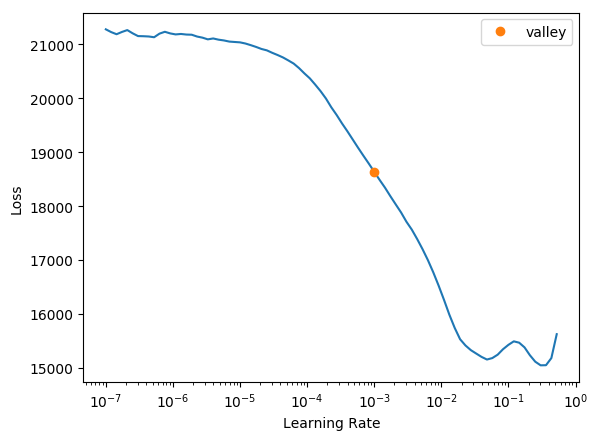

In [ ]:
plt.show()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(5, lr_max=lr)

epoch,train_loss,valid_loss,time
0,11404.983398,6467.290039,00:01
1,4589.362793,3144.360107,00:01
2,3391.427002,3045.519531,00:00
3,3100.954590,2939.373779,00:00
4,2987.387939,2892.937012,00:00


In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,time
0,3137.705322,3110.053467,00:00
1,3082.101074,2936.085693,00:00
2,3046.486084,2942.850342,00:00
3,3004.552734,2910.452148,00:00
4,2991.719727,2884.402832,00:00
5,2949.374268,2850.857666,00:00
6,2909.708008,2857.698975,00:00
7,2922.620117,2842.341797,00:00
8,2902.269531,2849.848145,00:00
9,2905.733643,2829.223389,00:00


In [ ]:
# learn.fit(10, lr=lr)

In [ ]:
to_test = dls.train_ds.new(df_test)
to_test.setup()
to_test.items.WindSpeed100m.describe()

count    7.210000e+03
mean    -1.389550e-16
std      1.000069e+00
min     -2.812462e+00
25%     -6.862164e-01
50%     -5.484845e-03
75%      7.133237e-01
max      3.003750e+00
Name: WindSpeed100m, dtype: float64

In [ ]:
dl_test = to_test.dataloaders(shuffle=False, drop_last=False)

In [ ]:
to_test.items.shape

(7210, 14)

In [ ]:
to_test.items.head(10)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-12-01 00:00:00+00:00,10,0.004303,1.317595,0.047618,1.181488,-0.010828,-0.022185,0.129585,1.410168,-0.475695,0.181064,1.393130,-0.435405,-0.836892
2012-12-01 01:00:00+00:00,10,0.031119,1.067006,-0.265119,0.959678,-0.264224,-0.679132,-0.061900,1.514067,-1.077824,0.014530,1.493850,-0.024540,-0.479349
2012-12-01 02:00:00+00:00,10,0.029213,1.575110,-0.318517,1.405821,-0.288010,0.113925,-0.292073,1.596604,-0.354621,-0.203402,1.585084,-0.683382,-1.083467
2012-12-01 03:00:00+00:00,10,0.065861,1.576064,-0.327368,1.417929,-0.283868,0.111353,-0.300972,1.598969,-0.331540,-0.202266,1.584715,0.111962,-0.357876
2012-12-01 04:00:00+00:00,10,0.233370,1.338913,-0.041227,1.211722,-0.061631,-0.074186,0.046176,1.459804,-0.485009,0.117595,1.435073,0.109383,-0.334719
2012-12-01 05:00:00+00:00,10,0.344251,1.482021,0.297296,1.332061,0.198473,0.476302,0.233342,1.337715,-0.006806,0.275255,1.321736,-0.076691,-0.488695
2012-12-01 06:00:00+00:00,10,0.104594,1.571839,0.458214,1.418300,0.335507,0.784330,0.288177,1.293990,0.290109,0.324880,1.279175,0.475384,-0.008913
2012-12-01 07:00:00+00:00,10,0.078106,1.487473,0.616665,1.358378,0.484848,0.874539,0.393926,1.197121,0.420478,0.428626,1.177118,0.784301,0.288983
2012-12-01 08:00:00+00:00,10,0.212753,1.196894,0.714028,1.112511,0.576322,0.678518,0.540985,1.026836,0.277789,0.568031,1.003584,0.874770,0.419783


In [ ]:
to_test.items.index.unique()

DatetimeIndex(['2012-12-01 00:00:00+00:00', '2012-12-01 01:00:00+00:00',
               '2012-12-01 02:00:00+00:00', '2012-12-01 03:00:00+00:00',
               '2012-12-01 04:00:00+00:00', '2012-12-01 05:00:00+00:00',
               '2012-12-01 06:00:00+00:00', '2012-12-01 07:00:00+00:00',
               '2012-12-01 08:00:00+00:00', '2012-12-01 09:00:00+00:00',
               ...
               '2012-12-30 15:00:00+00:00', '2012-12-30 16:00:00+00:00',
               '2012-12-30 17:00:00+00:00', '2012-12-30 18:00:00+00:00',
               '2012-12-30 19:00:00+00:00', '2012-12-30 20:00:00+00:00',
               '2012-12-30 21:00:00+00:00', '2012-12-30 22:00:00+00:00',
               '2012-12-30 23:00:00+00:00', '2012-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='TimeUTC', length=721, freq=None)

In [ ]:
yhat = learn.model(torch.tensor(to_test.cats.values).long().to("cuda:0"), torch.tensor(to_test.conts.values).float().to("cuda:0"))
yhat = to_np(yhat)

In [ ]:
yhat.shape

(7210, 99)

In [ ]:
# sort to avoid quantile crissing
yhat = np.sort(yhat, axis=1)

In [ ]:
to_test.items

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-12-01 00:00:00+00:00,10,0.004303,1.317595,0.047618,1.181488,-0.010828,-0.022185,0.129585,1.410168,-0.475695,0.181064,1.393130,-0.435405,-0.836892
2012-12-01 01:00:00+00:00,10,0.031119,1.067006,-0.265119,0.959678,-0.264224,-0.679132,-0.061900,1.514067,-1.077824,0.014530,1.493850,-0.024540,-0.479349
2012-12-01 02:00:00+00:00,10,0.029213,1.575110,-0.318517,1.405821,-0.288010,0.113925,-0.292073,1.596604,-0.354621,-0.203402,1.585084,-0.683382,-1.083467
2012-12-01 03:00:00+00:00,10,0.065861,1.576064,-0.327368,1.417929,-0.283868,0.111353,-0.300972,1.598969,-0.331540,-0.202266,1.584715,0.111962,-0.357876
2012-12-01 04:00:00+00:00,10,0.233370,1.338913,-0.041227,1.211722,-0.061631,-0.074186,0.046176,1.459804,-0.485009,0.117595,1.435073,0.109383,-0.334719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 20:00:00+00:00,9,0.000000,-0.593382,0.040796,-0.721426,0.310625,-1.567715,1.149621,-0.503606,-1.376958,1.103939,-0.867263,-1.347463,-1.516240
2012-12-30 21:00:00+00:00,9,0.000000,-0.667409,0.234324,-0.609853,0.187877,-1.268327,1.129873,-0.680415,-1.629415,1.157417,-0.658096,-1.568645,-1.379193
2012-12-30 22:00:00+00:00,9,0.000000,-0.610885,0.067887,-0.540448,0.042490,-1.525384,1.144364,-0.570865,-1.893174,1.180941,-0.447110,-1.269417,-1.631712


In [ ]:
y = to_test.ys.values

In [ ]:
y.shape

(7210, 1)

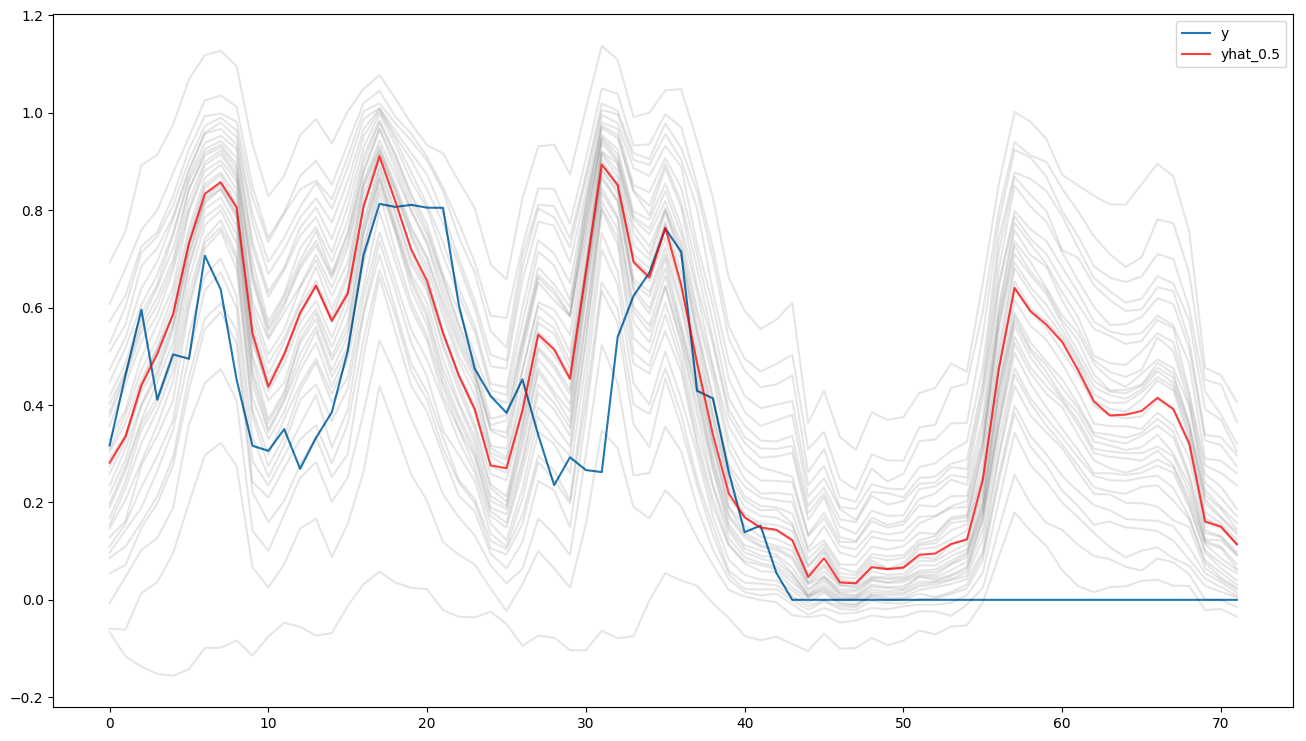

In [ ]:
plt.figure(figsize=(16,9))
start = 50
end = start+24*3
plt.plot(y[start:end], label="y")
for q_i in range(0, yhat.shape[1], 3):
    plt.plot(yhat[start:end, q_i], alpha=0.1, c="black")
    
plt.plot(yhat[start:end, len(quantiles)//2], alpha=0.75, c="red", label="yhat_0.5")
# plt.ylim(-1,2)
plt.legend()
plt.show()

In [ ]:
yhat.shape

(7210, 99)

In [ ]:
crps_mean = ps.crps_ensemble(y.reshape(-1), yhat).mean()

In [ ]:
crps_mean

0.0971151405685813

In [ ]:
crps_mean, crps_all = crps_for_quantiles(yhat, y.reshape(-1), quantiles=quantiles)
crps_mean

0.0951825492712665

In [ ]:
start_id, end_id = 0,0
crps_values = []
for k,df in to_test.items.groupby("TaskID"):
    start_id = end_id
    end_id = start_id + df.shape[0]
    crps_mean, _ = crps_for_quantiles(yhat[start_id:end_id,:], y[start_id:end_id,:].reshape(-1), quantiles=quantiles)
    crps_values.append(crps_mean)

/home/scribbler/anaconda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


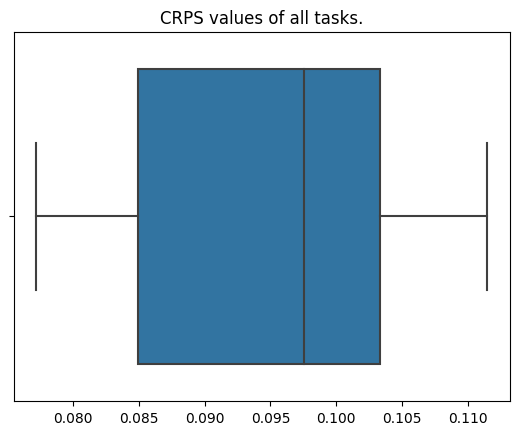

In [ ]:
sns.boxplot(crps_values)
plt.title("CRPS values of all tasks.")
plt.show()

In [ ]:
# dcor.energy_distance(y.reshape(-1), yhat)